In [1]:
from english_words import english_words_set
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import multiprocess as mp
import pandas as pd
import time
import pickle

In [2]:
# Set default plot style
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 3

## What intial guess is better for your odds?
A friend of mine who is much more experienced than me in this game told me starting with the word 'adieu' which contains the most vowels in any five letter words would maximize your chances. Without much knowledge about the game, that sounded fairly reasonable. However, with an inquisive mind, I decided to find out whether this hypothesis holds.

First we will define some functions in order to run the simulations.

In [3]:
# Function to clean the words set
def eligible_words(english_words_set):
    five_char_words = [word for word in english_words_set if len(word)==5 and not "'" in word]
    five_char_words_no_names = [word for word in five_char_words if word[0].isupper()==False]
    return five_char_words_no_names

# Return the result of a submission in terms of the correct, semicorrect & incorrect words
def submit(guess, answer, semicorrect=None, incorrect=None):
    """Check the guess against the answer"""
    correct = {}
    incorrect = [] if incorrect is None else incorrect
    semicorrect = {} if semicorrect is None else semicorrect
    counter = {char: 0 for char in guess}
    for i in range(5):
        if guess[i] == answer[i]:
            correct[i] = guess[i]
            counter[guess[i]] += 1
        elif guess[i] in answer and counter[guess[i]] < answer.count(guess[i]):
            semicorrect[i] = guess[i]
            counter[guess[i]] += 1
        else:
            incorrect.append(guess[i])
    return correct, semicorrect, list(set(incorrect))


# Filter words given the results of a guess
def find_words(words, correct, semicorrect, incorrect):
    incorrect = [char for char in incorrect if char not in list(correct.values()) + list(semicorrect.values())]
    # filter out all words containing incorrect characters
    words = [word for word in words if any(char in word for char in incorrect) == False]
    # filter words compatible with the correct characters
    words = [word for word in words if all(correct[i] == word[i] for i in correct)]
    # filter words containing the semicorrect characters
    words = [word for word in words if all(semicorrect[i] in word for i in semicorrect)]
    # fitler out words with characters in the positions of the semicorrect characters
    words = [word for word in words if all(semicorrect[i] != word[i] for i in semicorrect)]
    return words


# Return the number of attempts to solve a game
def crack(answer, words, init_guess=None, return_count=False, print_guess=False):
    correct = {}
    semicorrect = {}
    incorrect = []
    guess = random.choice(words) if not init_guess else init_guess
    guess_count = 0
    while len(correct) != 5:
        if print_guess:
            print(guess)
        correct, semicorrect, incorrect = submit(guess, answer, semicorrect, incorrect)
        words = find_words(words, correct, semicorrect, incorrect)
        guess = random.choice(words) 
        guess_count += 1
    if return_count:
        return guess_count
    return f'The answer is: {"".join(correct.values())}'

Below we will select 100 random words as answers for our experiment and for each word we will simulate the game 100 times.

In [4]:
word_list = eligible_words(english_words_set)
n_rand_words = 100
random_words = [random.choice(word_list) for i in range(n_rand_words)]

### Start the guess with the word with the most vowels: Adieu

In [5]:
n = 100
adieus = []
for word in random_words:
    for i in range(n):
        count = crack(word, word_list, init_guess='adieu', return_count=True)
        adieus.append(count)

<AxesSubplot:ylabel='Count'>

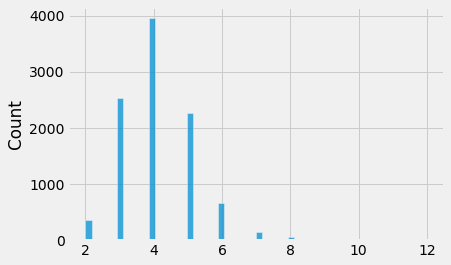

In [6]:
# plot the distribution
sns.histplot(adieus)

### Start with random guesses

In [7]:
rand_guess_count = []
for word in random_words:
    for i in range(n):
        count = crack(word, word_list, init_guess=None, return_count=True)
        rand_guess_count.append(count)

<AxesSubplot:ylabel='Count'>

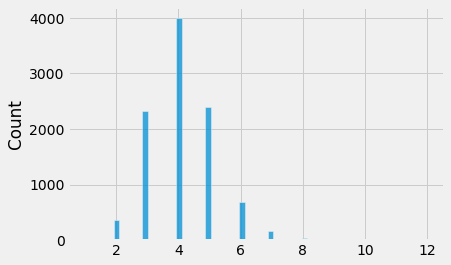

In [8]:
# plot the distribution
sns.histplot(rand_guess_count)

### Comparing the distributions
The two distributions above look very similar, in order to determine the difference between the distributions statistical test is needed with the following hypotheses:

H0 - null hypothesis: the two distributions are the same

H1 - alternate hypothesis: the distributions are different

In [9]:
# Kolmogorov–Smirnov test
stats.ks_2samp(adieus, rand_guess_count)

KstestResult(statistic=0.0189, pvalue=0.05619041963691477)

In [10]:
# Mann-Whitney U test
stats.mannwhitneyu(adieus, rand_guess_count)

MannwhitneyuResult(statistic=48914915.0, pvalue=0.005331077080487022)

In [11]:
# Chi-Square test
adieu_freq = [adieus.count(i) for i in set(rand_guess_count)]
rand_freq = [rand_guess_count.count(i) for i in set(rand_guess_count)]
stats.chisquare(adieu_freq, f_exp=rand_freq)

Power_divergenceResult(statistic=39.85089747371735, pvalue=3.793757193226987e-05)

In [12]:
# Z test when the sample size is large, T test otherwise
from statsmodels.stats import weightstats as stests
stests.ztest(adieus, rand_guess_count, value=0)

(-2.150799688532748, 0.03149201370679507)

After running the tests, both tests return a very low p-value, indicating strong evidence against the null hypothesis. With a critical value of 0.05, here we will reject the null hypothesis and conclude there's statistical significance in terms of the difference between the distributions.

### Which is the best starter word?
After the above comparison, we can see that some words are indeed better than others. In order to determine which word is the best starter word for the game, we will simulate the game a ton of times. Details as follows:
1. We will use the Wordle solutions of the first 200 days;
2. For each solution, we will run the game starting with every available 5-letter word for 10 times to determine the average no. of attempts to get the solution for that particular starter word

Since running the simulation ~5M times would be too slow, we will employ parallelization for the simulation. I have an 8-core laptop and it still took me a good hour, imagine without parallelization.

In [15]:
# Load 200 Wordle solutions (Day #0-#199)
with open('wordle_answers_0-200.txt', 'r') as f:
    answers = f.readlines()

answers = [ans.split()[-1].lower() for ans in answers]


# In case there are solutions that are not in the word list, we need to add those to our vocabulary
word_list = eligible_words(english_words_set)
word_list = list(set(word_list + answers))


# Function for simulation
def simulate_wordle(starter_word, n_attempt=10):
    result = {}
    attempt_counts = []
    for word in answers:
        for i in range(n_attempt):
            count = crack(word, word_list, init_guess=starter_word, return_count=True)
            attempt_counts.append(count)
    result[starter_word] = attempt_counts
    return result


# Multiprocessing
start = time.time()
pool = mp.Pool(mp.cpu_count())
results = pool.map(simulate_wordle, word_list)
pool.close()

# Since the entire simulation would take hours to complete
# to avoid wasting time on rerunning the simulation, we will save the result

results_ = {}
for d in results:
    results_.update(d)
pickle.dump(results_, open('simulation_result.pkl', 'wb'))

In [13]:
# Load simulation result
sim_result = pickle.load(open('simulation_result.pkl','rb'))

For each starter word, calculate:
1. Average no. of attempts to win
2. Variance/ standard deviation
3. Proportion of games that finish within 4 attempts
4. Proportion of games that finish within 6 attempts
5. Proportion of games that cannot finish within 6 attempts

In [14]:
# Summarize the results of each starter word
summary = {}
for key in sim_result:
    tmp_dict = {}
    tmp_array = np.array(sim_result[key])
    tmp_dict['avg_attempt'] = np.mean(tmp_array)
    tmp_dict['std'] = np.std(tmp_array)
    tmp_dict['within_four'] = len(np.where(tmp_array <= 4)[0])/len(tmp_array)
    tmp_dict['within_six'] = len(np.where(tmp_array <= 6)[0])/len(tmp_array)
    tmp_dict['beyond_six'] = len(np.where(tmp_array > 6)[0])/len(tmp_array)
    summary[key] = tmp_dict
    
# Construct a dataframe form the summary description
summary_df = pd.DataFrame({
    'starter word': list(summary.keys()),
    'avg attempt': [summary[key]['avg_attempt'] for key in summary],
    'std': [summary[key]['std'] for key in summary],
    'within four': [summary[key]['within_four'] for key in summary],
    'within six': [summary[key]['within_six'] for key in summary],
    'beyond six': [summary[key]['beyond_six'] for key in summary]
})
# Sort by avg. attempts
summary_df = summary_df.sort_values('avg attempt').reset_index(drop=True)

In [15]:
# Average attempts to win
summary_df['avg attempt'].mean()

4.214473631642029

In [16]:
# Top 5 best and worst starter words
summary_df.loc[list(range(0,5))+list(range(2498,2503))].style.background_gradient(subset=['avg attempt'])

,starter word,avg attempt,std,within four,within six,beyond six
0,trade,3.858500,1.084195,0.757000,0.986500,0.013500
1,trace,3.882500,1.124586,0.741000,0.986500,0.013500
2,crate,3.891000,1.110009,0.757000,0.980500,0.019500
3,tread,3.911000,1.111791,0.739500,0.983000,0.017000
4,alert,3.911500,1.040994,0.756000,0.986500,0.013500
2498,jiffy,4.665000,1.136123,0.466500,0.947000,0.053000
2499,mommy,4.666500,1.139859,0.463500,0.940500,0.059500
2500,jazzy,4.725000,1.146026,0.431000,0.942500,0.057500
2501,queue,4.750500,1.194257,0.428500,0.929000,0.071000
2502,mamma,4.816000,1.163677,0.406000,0.930500,0.069500


<AxesSubplot:>

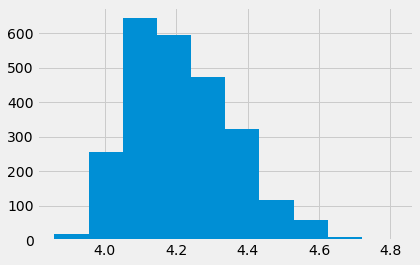

In [17]:
# Distribution of avg attempt
summary_df['avg attempt'].hist()

### Is it true that the more the vowels in the starter word, the better your chances?

In [18]:
# Count the number of unique vowels in each word
def count_unique_vowels(word):
    tmp_dict = {char: 0 for char in 'aeiou'}
    for char in word:
        if char in 'aeiou':
            tmp_dict[char] = 1
    return sum(tmp_dict.values())

summary_df['unique_vowels'] = summary_df['starter word'].apply(count_unique_vowels)

In [19]:
vowels = summary_df.groupby('unique_vowels').mean()
vowels.style.background_gradient(subset=['avg attempt'])

,avg attempt,std,within four,within six,beyond six
unique_vowels,,,,,
0,4.316750,1.068883,0.601550,0.973850,0.026150
1,4.267306,1.093336,0.622297,0.971606,0.028394
2,4.170181,1.109968,0.659820,0.972869,0.027131
3,4.193372,1.140133,0.651786,0.968231,0.031769
4,4.255250,1.196142,0.631500,0.959000,0.041000


<AxesSubplot:xlabel='unique_vowels', ylabel='avg attempt'>

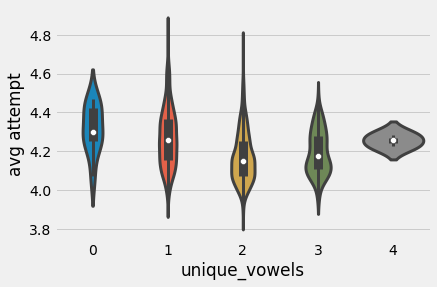

In [20]:
sns.violinplot(data=summary_df, x='unique_vowels', y='avg attempt')